# Waste-Assist Classification¶

In [ ]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1st Method - generating different augmented images each epoch (not saving images)

## Preprocessing the Training set

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.3,
                                   rotation_range=20,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split=0.1)

# tf.keras.preprocessing.image.ImageDataGenerator(
#     featurewise_center=False, samplewise_center=False,
#     featurewise_std_normalization=False, samplewise_std_normalization=False,
#     zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
#     height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
#     channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
#     horizontal_flip=False, vertical_flip=False, rescale=None,
#     preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
# )
drive_dir = '/content/drive/MyDrive/waste_assist'
local_dir = '../raw_data'
X_train_gen = train_datagen.flow_from_directory(
        f'{drive_dir}/training',
         target_size = (256, 256),
         batch_size = 32,
         class_mode = 'categorical',
         subset = 'training')

X_val_gen = train_datagen.flow_from_directory(
        f'{drive_dir}/training',
        target_size=(256, 256),
        batch_size=8,
        class_mode='categorical',
        subset = 'validation')
# flow_from_directory(
#     directory, target_size=(256, 256), color_mode='rgb', classes=None,
#     class_mode='categorical', batch_size=32, shuffle=True, seed=None,
#     save_to_dir=None, save_prefix='', save_format='png',
#     follow_links=False, subset=None, interpolation='nearest'
# )


Found 2412 images belonging to 7 classes.
Found 266 images belonging to 7 classes.


In [ ]:
X_train_gen.class_indices

{'cardboard': 0,
 'compost': 1,
 'glass': 2,
 'metal': 3,
 'paper': 4,
 'plastic': 5,
 'trash': 6}

## Preprocessing the Test set

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
X_test_gen = test_datagen.flow_from_directory(f'{drive_dir}/test',
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 73 images belonging to 7 classes.


In [ ]:
X_test_gen.class_indices

{'cartboard': 0,
 'compost': 1,
 'glass': 2,
 'metal': 3,
 'paper': 4,
 'plastic': 5,
 'trash': 6}

##Double checking the generator creates copies of images

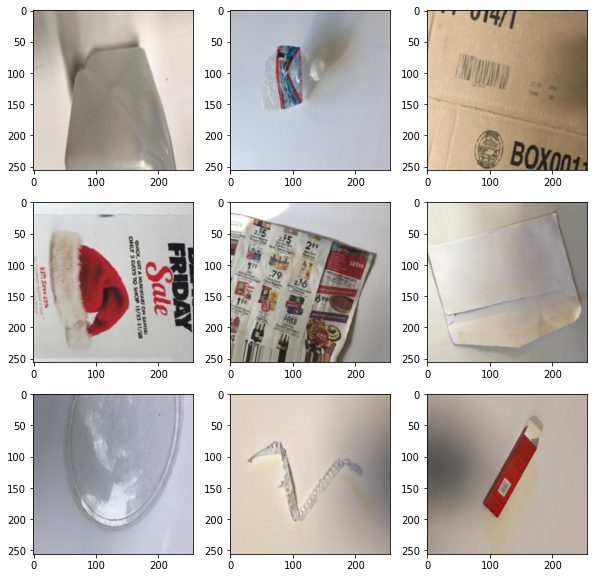

In [ ]:
plt.figure(figsize=(10,10))
# generate samples and plot
X_train_gen.reset()
batch = X_train_gen.next()
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(batch[0][i])

X_train_gen.reset()
# show the figure
plt.show()

# Building the CNN

In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

def initialize_model():
    '''instanciate and return the CNN architecture'''
    model = Sequential()

    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3), padding='valid'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (2,2), activation='relu', padding='valid'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(7, activation='softmax'))

    return model

In [ ]:
model = initialize_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 128)      

# Compiling and Training the CNN

In [ ]:
from tensorflow.keras import optimizers

def compile_model(model):
    '''return a compiled model suited for the cifar tasks'''
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics='accuracy')
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

baseline = 1/7 # select at random from 7 categories
model = compile_model(model)

es = EarlyStopping(patience=5, verbose=2)

In [106]:
history = model.fit(x=X_train_gen,
                    validation_data=X_val_gen,
                    callbacks=[es], 
                    epochs=100, 
                    batch_size=32,
                    use_multiprocessing=True,
                    workers = 10
                   )

Epoch 1/100
76/76 [==============================] - 341s 4s/step - loss: 1.9529 - accuracy: 0.2114 - val_loss: 1.8376 - val_accuracy: 0.2293
Epoch 2/100
76/76 [==============================] - 334s 4s/step - loss: 1.7654 - accuracy: 0.2902 - val_loss: 1.7536 - val_accuracy: 0.2932
Epoch 3/100
76/76 [==============================] - 346s 4s/step - loss: 1.6975 - accuracy: 0.3317 - val_loss: 1.6860 - val_accuracy: 0.3759
Epoch 4/100
76/76 [==============================] - 331s 4s/step - loss: 1.5870 - accuracy: 0.3582 - val_loss: 1.5892 - val_accuracy: 0.3083
Epoch 5/100
76/76 [==============================] - 346s 4s/step - loss: 1.5229 - accuracy: 0.3881 - val_loss: 1.5977 - val_accuracy: 0.3496
Epoch 6/100
76/76 [==============================] - 340s 4s/step - loss: 1.5252 - accuracy: 0.4046 - val_loss: 1.5400 - val_accuracy: 0.4060
Epoch 7/100
76/76 [==============================] - 340s 4s/step - loss: 1.4618 - accuracy: 0.4104 - val_loss: 1.5288 - val_accuracy: 0.3797
Epoch 

In [107]:
model.save(f'{drive_dir}/manual_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/waste_assist/manual_model/assets


In [108]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

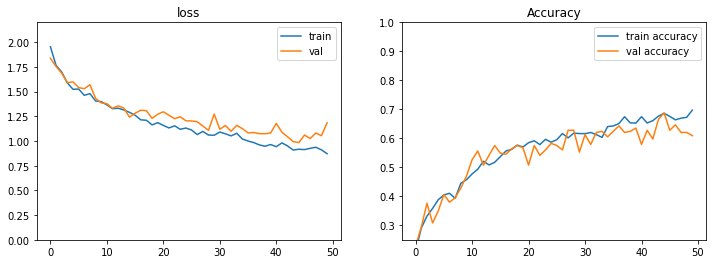

In [109]:
plot_history(history)
plt.show()

# Prediction

In [ ]:
model.evaluate(x=X_test_gen)

3/3 [==============================] - 12s 6s/step - loss: 1.1990 - accuracy: 0.6164


[1.1990344524383545, 0.6164383292198181]

#2nd Method - save the augmented images and use them 

In [ ]:
train_datagen2 = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.3,
                                   rotation_range=25,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split=0.1,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                                          )

# tf.keras.preprocessing.image.ImageDataGenerator(
#     featurewise_center=False, samplewise_center=False,
#     featurewise_std_normalization=False, samplewise_std_normalization=False,
#     zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
#     height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
#     channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
#     horizontal_flip=False, vertical_flip=False, rescale=None,
#     preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
# )
drive_dir = '/content/drive/MyDrive/waste_assist'
local_dir = '../raw_data'
X_train_gen_save = train_datagen2.flow_from_directory(
        f'{drive_dir}/training',
         target_size = (256, 256),
         batch_size = 32,
         class_mode = 'categorical',
         subset = 'training',
         save_to_dir = f'{drive_dir}/augmented',
         save_prefix = 'augmented',
         save_format = 'jpg')

# X_val_gen_save = train_datagen.flow_from_directory(
#         f'{drive_dir}/training',
#         target_size=(256, 256),
#         batch_size=8,
#         class_mode='categorical',
#         subset = 'validation')
# flow_from_directory(
#     directory, target_size=(256, 256), color_mode='rgb', classes=None,
#     class_mode='categorical', batch_size=32, shuffle=True, seed=None,
#     save_to_dir=None, save_prefix='', save_format='png',
#     follow_links=False, subset=None, interpolation='nearest'
# )
